In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sys
sys.path.append('../')

from src.evaluation import Evaluate
from src.genetic_programming import GeneticProgramming

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data preprocessing

The initial stage involves loading the dataset and selecting only the pertinent columns, using the Pandas library.

In [2]:
data = pd.read_csv("../data/2022.csv")
filter_cols = ["outTemp", "barometer", "dewpoint", "outHumidity", "windSpeed10"]
data = data.loc[:,filter_cols]
data.head()

,outTemp,barometer,dewpoint,outHumidity,windSpeed10
0,6.222222,1027.430167,-1.661668,57,1.609344
1,6.277778,1027.362440,-1.373265,58,3.218688
2,5.000000,1027.260848,-1.670748,62,3.218688
3,4.888889,1027.701078,-1.775836,62,1.609344
4,5.277778,1027.768806,-1.853178,60,1.609344


The dataset undergoes a two-fold process of division and scaling. This involves splitting the dataset and subsequently applying scaling, wherein the mean and standard deviation statistics computed from the training split are used to standardize the data. In essence, this step ensures that the dataset is prepared for further analysis or modeling by maintaining consistency in its numerical values across different features.

In [3]:
scaler = preprocessing.StandardScaler()

scaler.fit(data.iloc[0:4000,:]) # Standardize only the training part
scaled_data = data
scaled_data[filter_cols] = scaler.transform(data)

# Split the dataset
train_data = scaled_data.iloc[:4000]
val_data = scaled_data.iloc[4000:4500]
test_data = scaled_data.iloc[4500:]

The preparation of the dataset involves the generation of sequences with a specified length, denoted as `seq_len`. The resulting dataset comprises these sequences along with corresponding temperature values for the subsequent hour. 

In [4]:
def prepare_dataset(data, seq_len):
    """
    Prepare the dataset by creating a all the possible sequences of length
    seq_len.

    Parameters
    ----------
    data : pandas dataframe containing the entire weather dataset 
    seq_len : the length of the sequence corresponding to the number of prior 
      weather samples used for prediction.
    """
    X = torch.zeros((data.shape[0] - seq_len, seq_len, data.size(1)), device=device)
    Y = []

    # Prepare the sequences of length seq_len
    for i in range(data.size(0) - seq_len):
      X[i,:] = data[i:i+seq_len,:]
      Y.append(data[i+seq_len,0])
    return X, torch.tensor(Y, device=device)

# Sequence length
seq_len = 4

X_train, Y_train = prepare_dataset(torch.tensor(train_data.values, device=device), seq_len)
X_val, Y_val = prepare_dataset(torch.tensor(val_data.values, device=device), seq_len)
X_test, Y_test = prepare_dataset(torch.tensor(test_data.values, device=device), seq_len)

## Genetic Programming

Next, initiate genetic programming with a population size of `500` individuals, a tournament size of `5`, and limit the training to the initial `100` samples of the dataset. The size of the training set is reduced to the first `100` samples due to the impracticality of using the entire training set given the number of individuals in the population, which would require excessive time. The validation set is employed, similar to the other method, to measure the model's ability to generalize and select the model that exhibits better generalization without overfitting the training data.

In [5]:
gp = GeneticProgramming(seq_len=seq_len, pop_size=500, tournament_size=5, 
                        halloffame_size=1, X_train=X_train[:100], Y_train=Y_train[:100], 
                        X_val=X_val, Y_val=Y_val, device=device)

final_pop, logbook = gp.run(num_generations=20, crossover_prob=0.8, mutation_prob=0.1)

   	      	                   fitness                    	                 size                 
   	      	----------------------------------------------	--------------------------------------
gen	nevals	avg   	gen	max    	min      	nevals	avg  	gen	max	min	nevals
0  	500   	29.149	0  	12962.6	0.0858469	500   	7.308	0  	15 	3  	500   
1  	422   	0.697555	1  	12.1278	0.0843066	422   	7.16 	1  	17 	2  	422   
MAE GP: 0.144850
2  	424   	0.633389	2  	22.0539	0.0843066	424   	6.024	2  	15 	2  	424   
MAE GP: 0.144850
3  	424   	0.470432	3  	19.1636	0.0795078	424   	5.472	3  	15 	2  	424   
MAE GP: 0.123995
4  	404   	6.03028 	4  	2812.57	0.0795078	404   	5.018	4  	15 	2  	404   
MAE GP: 0.123995
5  	415   	0.865047	5  	68.4869	0.0761718	415   	5.032	5  	16 	2  	415   
MAE GP: 0.125910
6  	372   	0.734235	6  	26.8278	0.0761718	372   	5.35 	6  	16 	2  	372   
MAE GP: 0.125910
7  	431   	0.759515	7  	26.8278	0.0761718	431   	5.978	7  	18 	2  	431   
MAE GP: 0.125910
8  	417   	1.98679 	8  	4

Let's retrieve the best individual from the initial candidate in the hall of fame and display its details.

In [6]:
func = gp.compileCandidate(gp.halloffame[0])
print(gp.halloffame[0])

sub(protectedDiv(ARG3, protectedDiv(ARG3, ARG3)), mul(sub(ARG0, mul(mul(ARG3, 0.9705874696744737), 0.9705874696744737)), 0.17488321292750486))


## Evaluation

The fitness progress over the generations is shown in the following plot which illustrates the best model’s fitness evaluated on the training set at the end of each generation as well as the average size of the evolved trees.

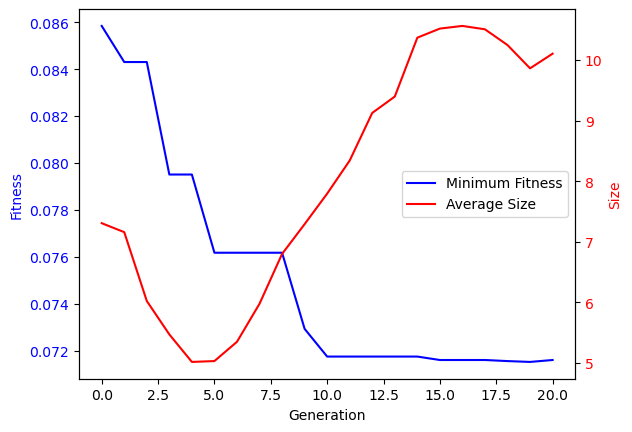

In [7]:
gen = logbook.select("gen")
fit_mins = logbook.chapters["fitness"].select("min")
size_avgs = logbook.chapters["size"].select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.show()

Now, the model is evaluated on the complete test set to facilitate comparison with other models. The outcomes reveal the superiority of the Genetic Programming-based model over the baseline, achieving a Mean Absolute Error (MAE) of `0.0929`, which is notably smaller than the baseline method's MAE of `0.1126`.

<Figure size 640x480 with 0 Axes>

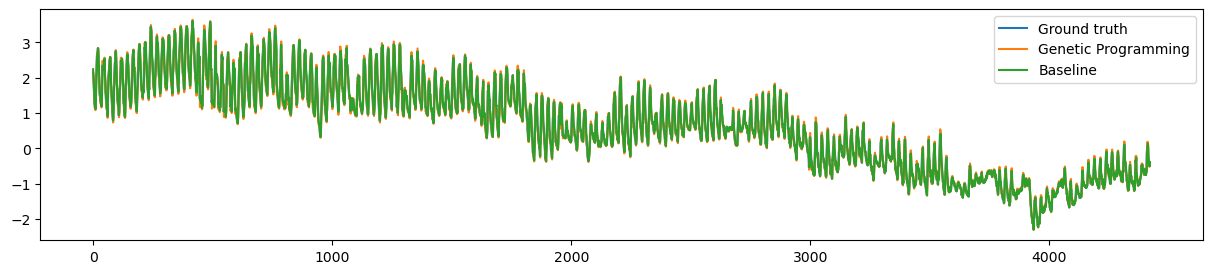

MAE GP: 0.092960
MAE baseline: 0.112613


In [8]:
ev = Evaluate(device=device)
mae_gp, mae_baseline = ev.evaluateMaeGp(func, test_data, seq_len=seq_len, plot=True)

print('MAE GP: %f' % (mae_gp)) 
print('MAE baseline: %f' % (mae_baseline)) 

Ultimately, for visualization purposes, the model is evaluated on the initial `200` samples of the test dataset. The qualitative outcomes distinctly demonstrate that the model derived from genetic programming exhibits a closer proximity to the ground truth outdoor temperature when contrasted with the baseline.

<Figure size 640x480 with 0 Axes>

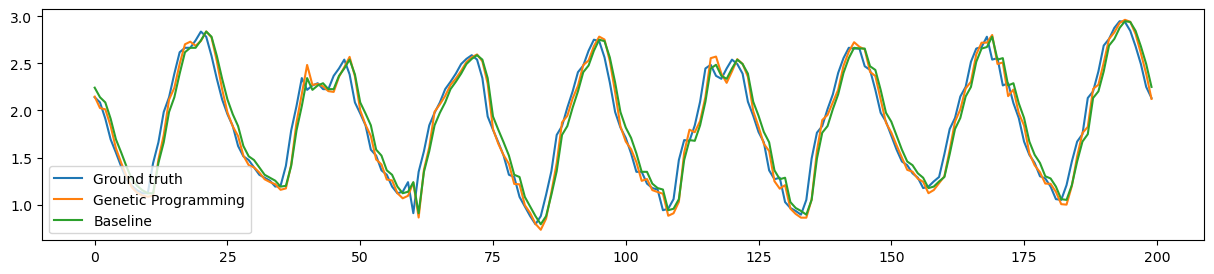

In [9]:
ev = Evaluate(device=device)
mae_gp, mae_baseline = ev.evaluateMaeGp(func, test_data[:300], seq_len=seq_len, plot=True)